# 🧪 Expérimentations - Apprentissage par renforcement
Dans ce notebook, nous comparons plusieurs algorithmes (Monte Carlo, Q-Learning, Expected SARSA, Dyna-Q, Dyna-Q+)
sur des environnements comme Monty Hall Level 1.

## Imports

In [1]:
import argparse
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt

# === Environnements ===
from reinfolearn.environment.grid_world import GridWorldMDP
from reinfolearn.environment.line_world import LineWorldMDP
from reinfolearn.environment.montyhall_level1 import MontyHallLevel1MDP
from reinfolearn.environment.montyhall_level2 import MontyHallLevel2MDP
from reinfolearn.environment.rock_paper_scissors import RockPaperScissorsMDP
from reinfolearn.environment.rock_paper_scissors_two_rounds import TwoRoundRPS



# === Algorithmes ===
from reinfolearn.algorithm.dp.policy_iteration import policy_iteration
from reinfolearn.algorithm.dp.value_iteration import value_iteration
from reinfolearn.algorithm.mc.mc_on_policy import mc_on_policy_first_visit
from reinfolearn.algorithm.mc.mc_off_policy import mc_off_policy_control
from reinfolearn.algorithm.mc.mc_exploring_starts import mc_exploring_starts
from reinfolearn.algorithm.td.q_learning import q_learning
from reinfolearn.algorithm.td.sarsa import sarsa
from reinfolearn.algorithm.td.expected_sarsa import expected_sarsa
from reinfolearn.algorithm.pn.dyna_q import dyna_q
from reinfolearn.algorithm.pn.dyna_q_plus import dyna_q_plus

# === Utilitaires ===
from reinfolearn.utils.io_utils import save_policy, save_q_table, save_values, save_scores
from reinfolearn.utils.plot_utils import plot_scores, plot_convergence, plot_unified
from reinfolearn.utils.metrics_utils import evaluate_policy_score, summarize_policy_scores

## Fonction standard d'expérimentation

In [2]:
def get_env(env_name):
    envs = {
        "grid": GridWorldMDP(),
        "line": LineWorldMDP(),
        "monty": MontyHallLevel1MDP(),
        "monty_level2": MontyHallLevel2MDP(),
        "rps": RockPaperScissorsMDP(),
        "rps_two_rounds": TwoRoundRPS()
    }
    return envs[env_name]

In [3]:
def run_experiment(env_class, algo_fn, algo_name, env_name, **kwargs):
    env = env_class()

    # create output directory if it doesn't exist
    output_dir = f"outputs/{env_name}/{algo_name}"
    os.makedirs(output_dir, exist_ok=True)

    if algo_name == "policy_iteration":
        policy, V, mean_value_history = algo_fn(env, **kwargs)
        save_policy(policy, f"{output_dir}/policy.json")
        save_values(V, f"{output_dir}/values.npy") # Save values for policy iteration
        save_scores(mean_value_history, f"{output_dir}/value_convergence.npy")

        print(f"Politique et valeurs sauvegardées pour {env_name} avec {algo_name}")
        return policy, V, mean_value_history
    
    elif algo_name == "value_iteration":
        policy, V, delta_history = algo_fn(env, **kwargs)
        save_policy(policy, f"{output_dir}/policy.json")
        save_values(V, f"{output_dir}/values.npy") # Save values for value iteration
        save_scores(delta_history, f"{output_dir}/delta_convergence.npy")

        print(f"Politique et valeurs sauvegardées pour {env_name} avec {algo_name}")
        return policy, V, delta_history
    else:
        policy, Q, scores = algo_fn(env, **kwargs)
        save_policy(policy, f"{output_dir}/policy.json")
        save_q_table(Q, f"{output_dir}/q_table.pkl") # Save Q-table for TD methods
        save_scores(scores, f"{output_dir}/episode_scores.npy")
    return policy, Q, scores

## Expérimentation

Dans cette section, nous allons exécuter les algorithmes sur différents environnements et collecter les scores. 

### Étude sur l'environnement line

In [4]:
env_name = "line"
env_class = LineWorldMDP

# Policy Iteration
policy_pi, V_pi, _ = run_experiment(
    env_class, policy_iteration, "policy_iteration", env_name,
    gamma=0.99, theta=1e-6, max_iterations=1000)
scores_pi = evaluate_policy_score(env_class(), policy_pi, nb_episodes=10)
summary_pi = summarize_policy_scores(scores_pi)
print("Policy Iteration summary:", summary_pi)

# Pour Value Iteration
policy_vi, V_vi, _ = run_experiment(env_class, value_iteration, "value_iteration", env_name,
    gamma=0.99, theta=1e-6, max_iterations=1000)
scores_vi = evaluate_policy_score(env_class(), policy_vi, nb_episodes=10)
summary_vi = summarize_policy_scores(scores_vi)
print("Value Iteration summary:", summary_vi)

# Pour Monte Carlo Off-Policy Control
policy_mc_off_policy, Q_mc_off_policy, scores_mc_off_policy = run_experiment(
    env_class, mc_off_policy_control, "Monte Carlo Off-Policy", env_name,
   nb_episodes=10, gamma=0.99)


# MC On-policy First Visit
policy_mc_on_policy, Q_mc_on_policy, scores_mc_on_policy = run_experiment(
    env_class, mc_on_policy_first_visit, "Monte Carlo On-Policy First Visit", env_name,
    nb_episodes=10, gamma=0.99, epsilon=0.01)

# MC Exploring Starts
policy_mc_exploring_starts, Q_mc_exploring_starts, scores_mc_exploring_starts = run_experiment(
    env_class, mc_exploring_starts, "Monte Carlo Exploring Starts", env_name,
    nb_episodes=10, gamma=0.99)

# Q-learning
policy_q, Q_q, scores_q = run_experiment(
    env_class, q_learning, "Q-Learning", env_name,
    nb_episodes=10, gamma=0.99, alpha=0.1, epsilon=0.01)

# Expected SARSA
policy_esarsa, Q_esarsa, scores_esarsa = run_experiment(
    env_class, expected_sarsa, "Expected SARSA", env_name,
    nb_episodes=10, gamma=0.99, alpha=0.1, epsilon=0.01)

# SARSA
policy_sarsa, Q_sarsa, scores_sarsa = run_experiment(
    env_class, sarsa, "SARSA", env_name,
    nb_episodes=10, gamma=0.99, alpha=0.1, epsilon=0.01)

# Dyna-Q
policy_dq, Q_dq, scores_dq = run_experiment(
    env_class, dyna_q, "Dyna-Q", env_name,
    nb_episodes=10, gamma=0.99, alpha=0.1, epsilon=0.01, planning_steps=20)

# Dyna-Q+
policy_dqplus, Q_dqplus, scores_dqplus = run_experiment(
    env_class, dyna_q_plus, "Dyna-Q+", env_name,
    nb_episodes=10, gamma=0.99, alpha=0.1, epsilon=0.01, planning_steps=20, kappa=1e-4)



Policy Iteration:   0%|          | 1/1000 [00:00<00:02, 492.87it/s]


Politique et valeurs sauvegardées pour line avec policy_iteration


Évaluation de la politique: 100%|██████████| 10/10 [00:00<00:00, 889.89it/s]


Policy Iteration summary: {'mean': np.float64(1.0), 'std': np.float64(0.0), 'min': np.float64(1.0), 'max': np.float64(1.0)}
Politique et valeurs sauvegardées pour line avec value_iteration


Évaluation de la politique: 100%|██████████| 10/10 [00:00<00:00, 30795.18it/s]


Value Iteration summary: {'mean': np.float64(1.0), 'std': np.float64(0.0), 'min': np.float64(1.0), 'max': np.float64(1.0)}


Dyna-Q+: 100%|██████████| 10/10 [00:00<00:00, 703.79it/s]


#### Comparaison graphique des performances

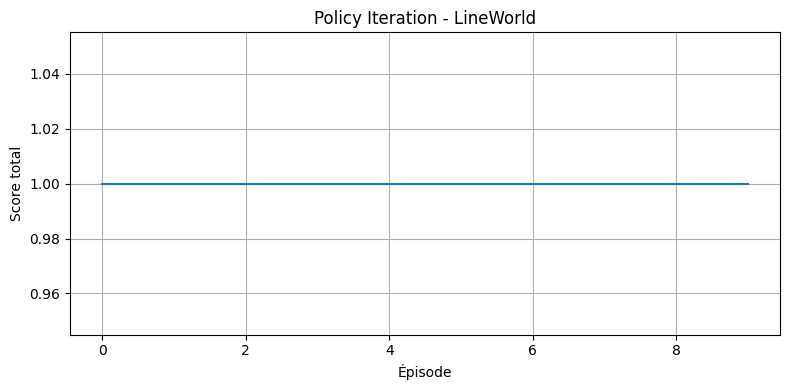

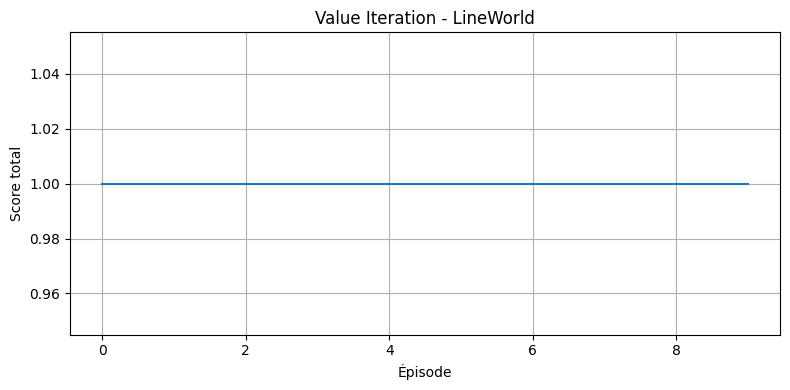

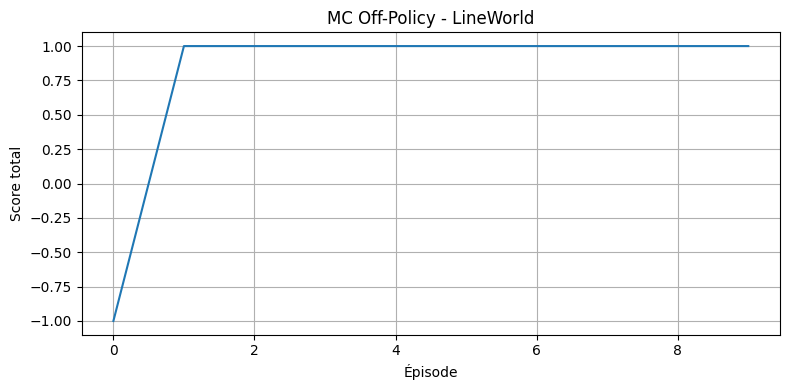

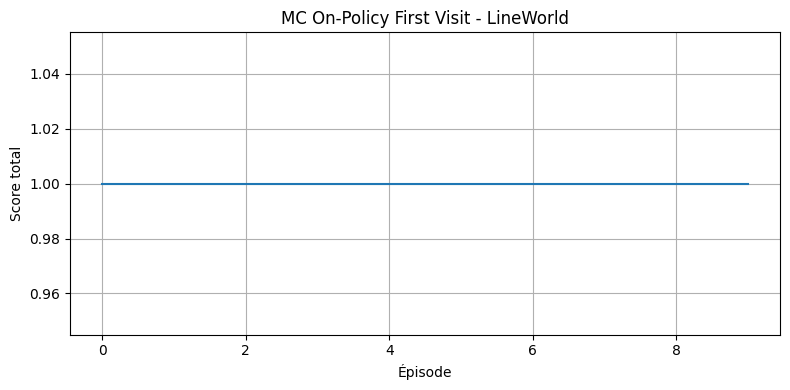

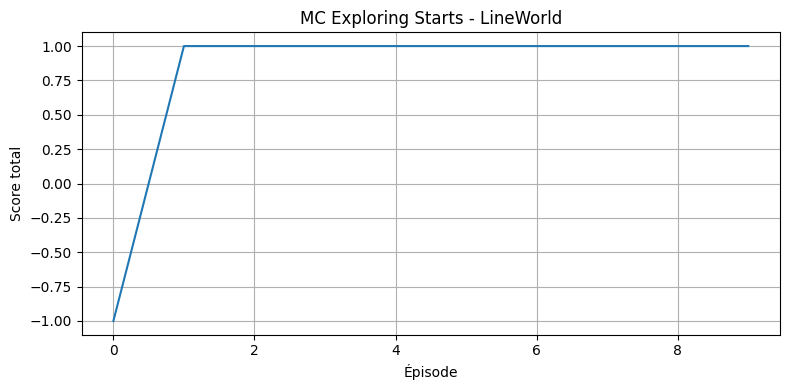

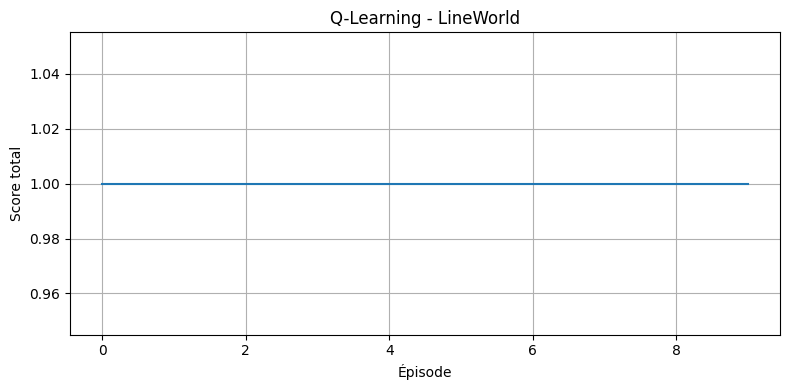

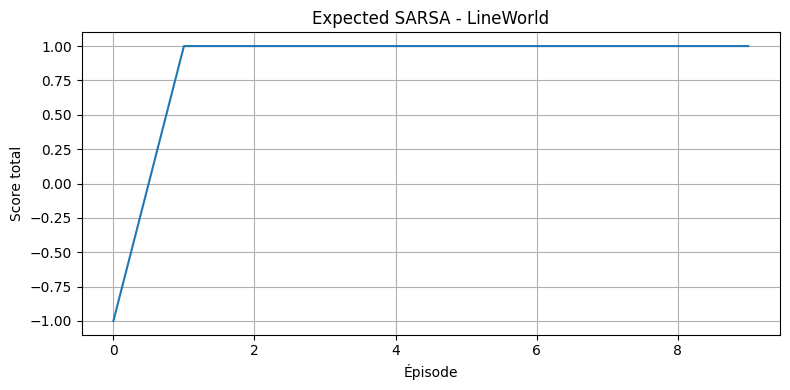

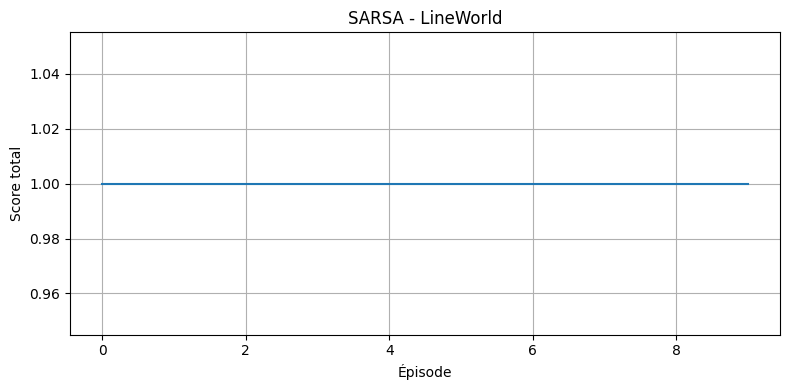

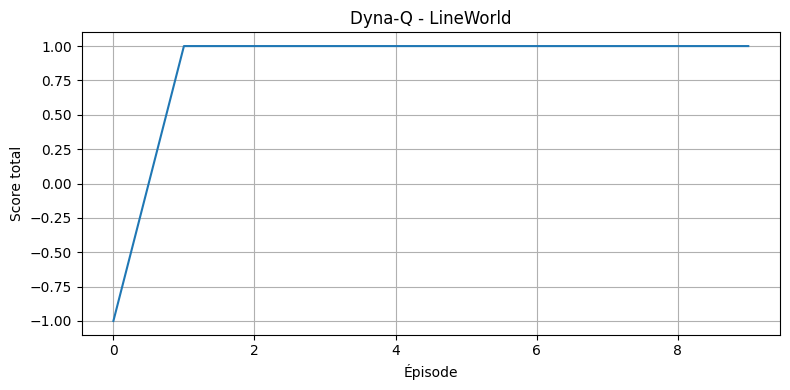

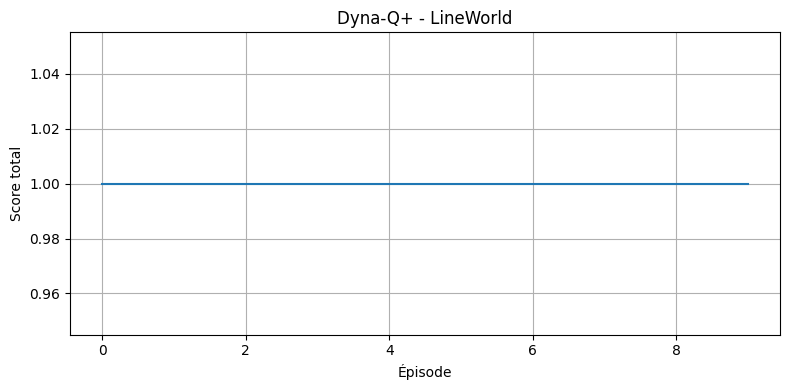

In [5]:
algorithms_data = {
    "Policy Iteration": scores_pi,
    "Value Iteration": scores_vi,
    "MC Off-Policy": scores_mc_off_policy,
    "MC On-Policy": scores_mc_on_policy,
    "MC Exploring Starts": scores_mc_exploring_starts,
    "Q-Learning": scores_q,
    "Expected SARSA": scores_esarsa,
    "SARSA": scores_sarsa,
    "Dyna-Q": scores_dq,
    "Dyna-Q+": scores_dqplus
}

plot_unified(
    algorithms_data, 
    title="Comparaison des algorithmes - LineWorld",
    ylabel="Score",
    window=None
)


#### Interpretation  **line world** : 

L’environnement LineWorld étant extrêmement simple, avec une dynamique totalement déterministe et une structure linéaire très restreinte, tous les algorithmes convergent très rapidement vers la solution optimale. Les méthodes de Dynamic Programming (Value Iteration, Policy Iteration) trouvent immédiatement la politique optimale puisqu’elles exploitent directement le modèle connu des transitions. Les algorithmes Monte Carlo atteignent également le score optimal, mais nécessitent au moins un ou deux épisodes pour converger, le temps d’échantillonner les résultats possibles. Quant aux approches basées sur le Temporal Difference Learning (Sarsa, Expected Sarsa, Q-Learning), elles convergent sans difficulté, bien que leur capacité d’exploration et d’adaptation soit sous-exploitée ici du fait de la faible complexité de l’environnement. Enfin, les méthodes de Planning comme Dyna-Q n’apportent aucun bénéfice particulier dans ce contexte, car l’environnement ne nécessite pas de modélisation pour être résolu efficacement. Globalement, ces résultats confirment que les algorithmes les plus adaptés à LineWorld sont ceux qui exploitent directement un modèle connu, comme DP ou Value Iteration, là où les méthodes d’exploration sont ici superflues.

### Étude sur l'environnement grid

In [6]:
env_name = "grid"
env_class = GridWorldMDP

# Policy Iteration
policy_pi, V_pi, _ = run_experiment(
    env_class, policy_iteration, "policy_iteration", env_name,
    gamma=0.99, theta=1e-6, max_iterations=1000)

scores_pi = evaluate_policy_score(env_class(), policy_pi, nb_episodes=10)
summary_pi = summarize_policy_scores(scores_pi)
print("Policy Iteration summary:", summary_pi)

# Pour Value Iteration
policy_vi, V_vi, _ = run_experiment(env_class, value_iteration, "value_iteration", env_name,
    gamma=0.99, theta=1e-6, max_iterations=1000)
scores_vi = evaluate_policy_score(env_class(), policy_vi, nb_episodes=10)
summary_vi = summarize_policy_scores(scores_vi)
print("Value Iteration summary:", summary_vi)

# Pour Monte Carlo Off-Policy Control
policy_mc_off_policy, Q_mc_off_policy, scores_mc_off_policy = run_experiment(
    env_class, mc_off_policy_control, "Monte Carlo Off-Policy", env_name,
   nb_episodes=10, gamma=0.99)


# MC On-policy First Visit
policy_mc_on_policy, Q_mc_on_policy, scores_mc_on_policy = run_experiment(
    env_class, mc_on_policy_first_visit, "Monte Carlo On-Policy First Visit", env_name,
    nb_episodes=10, gamma=0.99, epsilon=0.01)

# MC Exploring Starts
policy_mc_exploring_starts, Q_mc_exploring_starts, scores_mc_exploring_starts = run_experiment(
    env_class, mc_exploring_starts, "Monte Carlo Exploring Starts", env_name,
    nb_episodes=10, gamma=0.99)

# Q-learning
policy_q, Q_q, scores_q = run_experiment(
    env_class, q_learning, "Q-Learning", env_name,
    nb_episodes=10, gamma=0.99, alpha=0.1, epsilon=0.01)

# Expected SARSA
policy_esarsa, Q_esarsa, scores_esarsa = run_experiment(
    env_class, expected_sarsa, "Expected SARSA", env_name,
    nb_episodes=10, gamma=0.99, alpha=0.1, epsilon=0.01)

# SARSA
policy_sarsa, Q_sarsa, scores_sarsa = run_experiment(
    env_class, sarsa, "SARSA", env_name,
    nb_episodes=10, gamma=0.99, alpha=0.1, epsilon=0.01)

# Dyna-Q
policy_dq, Q_dq, scores_dq = run_experiment(
    env_class, dyna_q, "Dyna-Q", env_name,
    nb_episodes=10, gamma=0.99, alpha=0.1, epsilon=0.01, planning_steps=20)

# Dyna-Q+
policy_dqplus, Q_dqplus, scores_dqplus = run_experiment(
    env_class, dyna_q_plus, "Dyna-Q+", env_name,
    nb_episodes=10, gamma=0.99, alpha=0.1, epsilon=0.01, planning_steps=20, kappa=1e-4)


Policy Iteration:   1%|          | 7/1000 [00:00<00:35, 27.87it/s]


Politique et valeurs sauvegardées pour grid avec policy_iteration


Évaluation de la politique: 100%|██████████| 10/10 [00:00<00:00, 26990.37it/s]


Policy Iteration summary: {'mean': np.float64(1.0), 'std': np.float64(0.0), 'min': np.float64(1.0), 'max': np.float64(1.0)}
Politique et valeurs sauvegardées pour grid avec value_iteration


Évaluation de la politique: 100%|██████████| 10/10 [00:00<00:00, 46916.15it/s]


Value Iteration summary: {'mean': np.float64(1.0), 'std': np.float64(0.0), 'min': np.float64(1.0), 'max': np.float64(1.0)}


Dyna-Q+: 100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


#### Comparaison graphique des performances

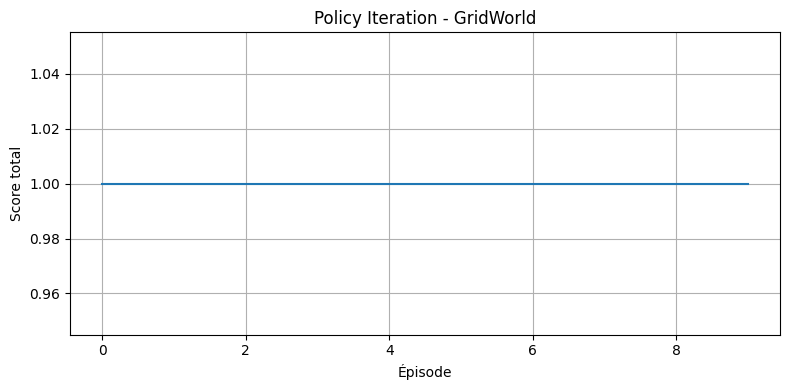

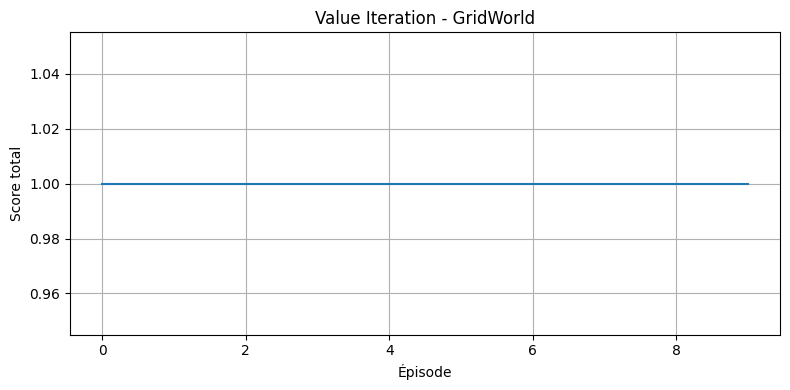

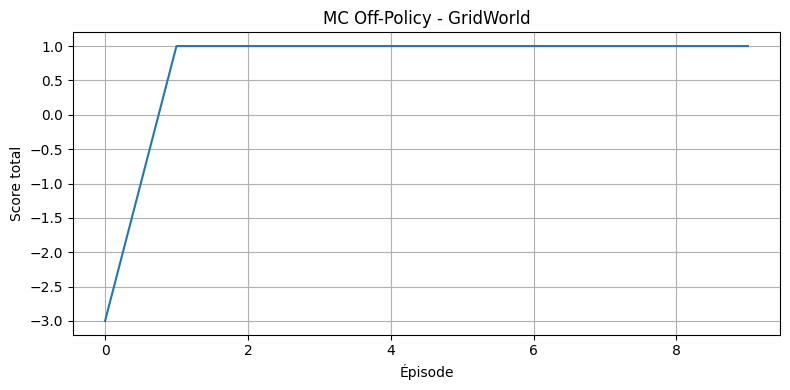

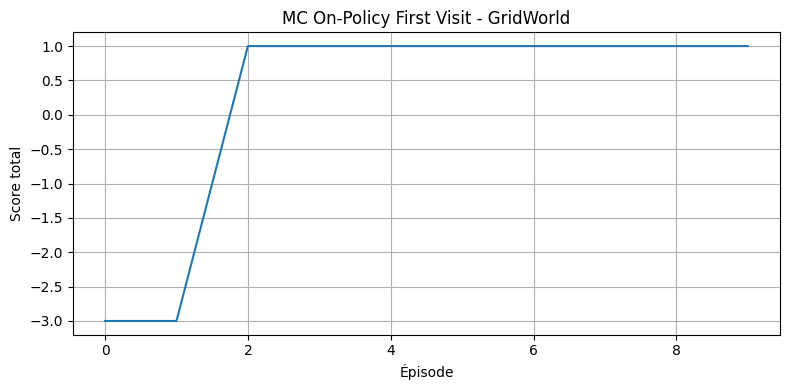

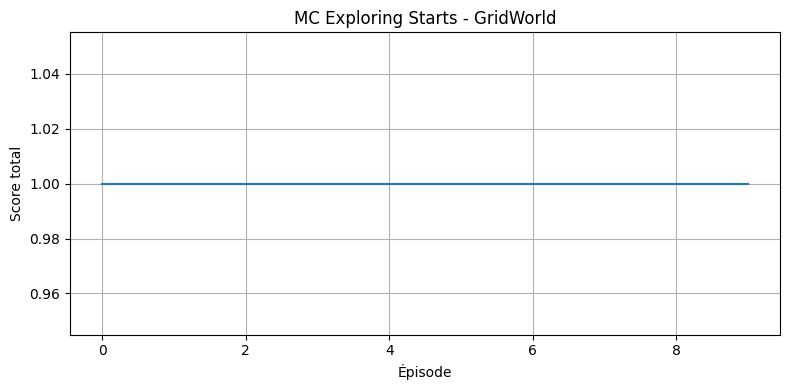

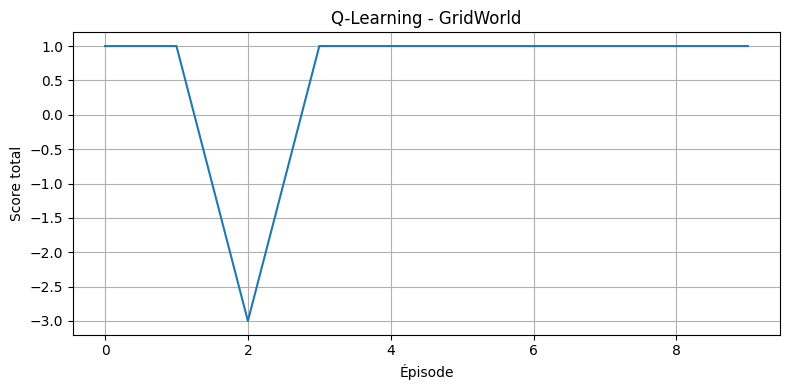

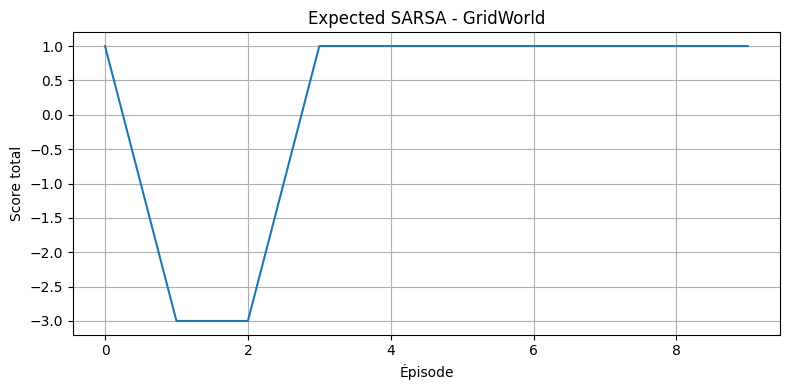

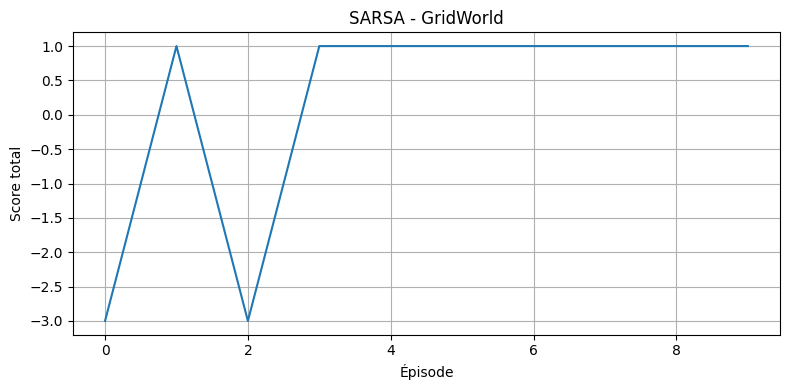

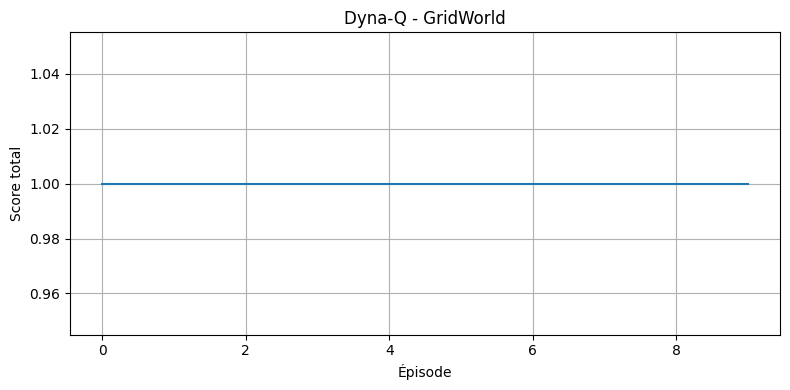

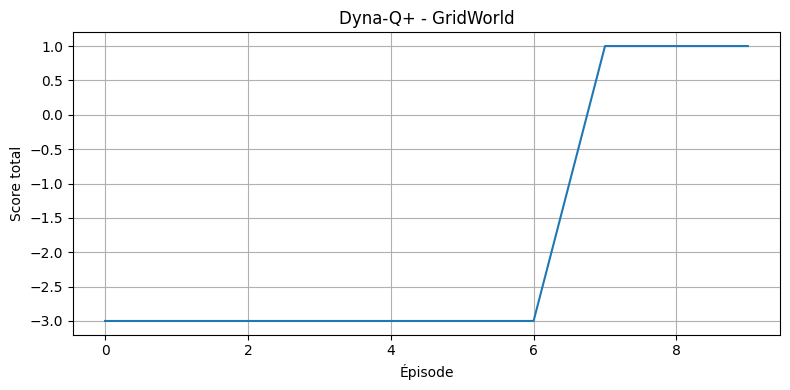

In [7]:
algorithms_data = {
    "Policy Iteration": scores_pi,
    "Value Iteration": scores_vi,
    "MC Off-Policy": scores_mc_off_policy,
    "MC On-Policy": scores_mc_on_policy,
    "MC Exploring Starts": scores_mc_exploring_starts,
    "Q-Learning": scores_q,
    "Expected SARSA": scores_esarsa,
    "SARSA": scores_sarsa,
    "Dyna-Q": scores_dq,
    "Dyna-Q+": scores_dqplus
}

plot_unified(
    algorithms_data, 
    title="Comparaison des algorithmes - GridWorld",
    ylabel="Score",
    window=None
)


#### Interpretation grid world : 
L’environnement GridWorld est légèrement plus complexe que LineWorld mais reste simple, entièrement déterministe et connu de l’agent. Les algorithmes de Dynamic Programming, tels que Policy Iteration et Value Iteration, convergent immédiatement vers la politique optimale sans nécessiter d’exploration empirique, ce qui se reflète par un score constant dès le départ. À l’inverse, les méthodes Monte Carlo (On-Policy, Off-Policy, Exploring Starts) montrent une légère phase d’adaptation au début, nécessitant de vivre quelques épisodes pour comprendre la dynamique et corriger la politique. Une fois l’environnement exploré, ces méthodes parviennent elles aussi à maximiser le score. Pour les algorithmes de TD Learning (Q-Learning, Sarsa, Expected Sarsa), on observe des oscillations en début d’apprentissage dues à leur nécessité d’explorer activement l’environnement et d’ajuster leur politique progressivement. Toutefois, après quelques épisodes, ils convergent également vers le comportement optimal attendu. Enfin, les méthodes de Planning (Dyna-Q, Dyna-Q+) sont ici peu pertinentes dans un environnement aussi simple et connu, mais elles permettent d’atteindre un résultat satisfaisant. On remarque néanmoins un léger décalage dans l’adaptation de Dyna-Q+, qui met plus de temps à converger que Dyna-Q, ce qui s’explique par son mécanisme favorisant l’exploration de transitions rares

### Étude sur l'environnement MontyHallLevel1MDP

In [8]:
env_name = "monty"
env_class = MontyHallLevel1MDP

def run_experiment(env_class, algo_fn, algo_name, env_name, **kwargs):
    env = env_class()

    # create output directory if it doesn't exist
    output_dir = f"outputs/{env_name}/{algo_name}"
    os.makedirs(output_dir, exist_ok=True)

    if algo_name == "policy_iteration":
        policy, V, mean_value_history = algo_fn(env, **kwargs)
        save_policy(policy, f"{output_dir}/policy.json")
        save_values(V, f"{output_dir}/values.npy") # Save values for policy iteration
        save_scores(mean_value_history, f"{output_dir}/value_convergence.npy")

        print(f"Politique et valeurs sauvegardées pour {env_name} avec {algo_name}")
        return policy, V, mean_value_history
    
    elif algo_name == "value_iteration":
        policy, V, delta_history = algo_fn(env, **kwargs)
        save_policy(policy, f"{output_dir}/policy.json")
        save_values(V, f"{output_dir}/values.npy") # Save values for value iteration
        save_scores(delta_history, f"{output_dir}/delta_convergence.npy")

        print(f"Politique et valeurs sauvegardées pour {env_name} avec {algo_name}")
        return policy, V, delta_history
    else:
        policy, Q, scores = algo_fn(env, **kwargs)
        save_policy(policy, f"{output_dir}/policy.json")
        save_q_table(Q, f"{output_dir}/q_table.pkl") # Save Q-table for TD methods
        save_scores(scores, f"{output_dir}/episode_scores.npy")
    return policy, Q, scores

#### Comparaison graphique des performances

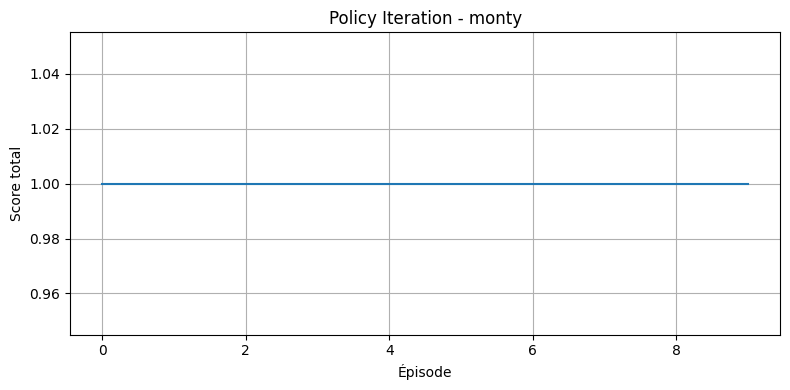

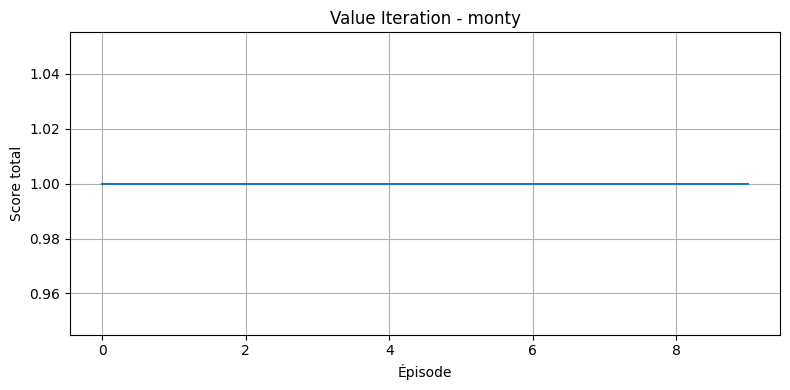

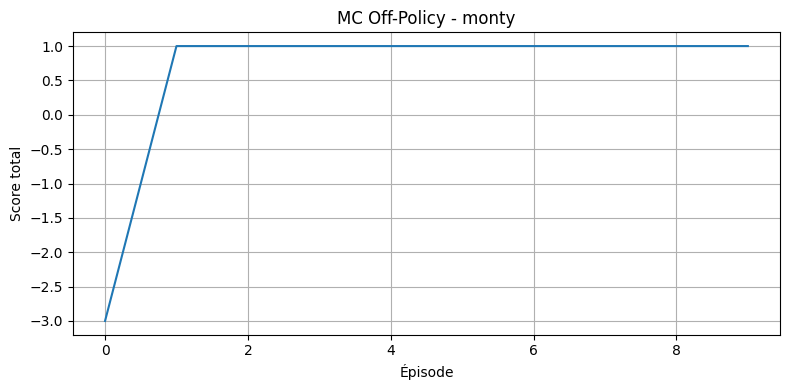

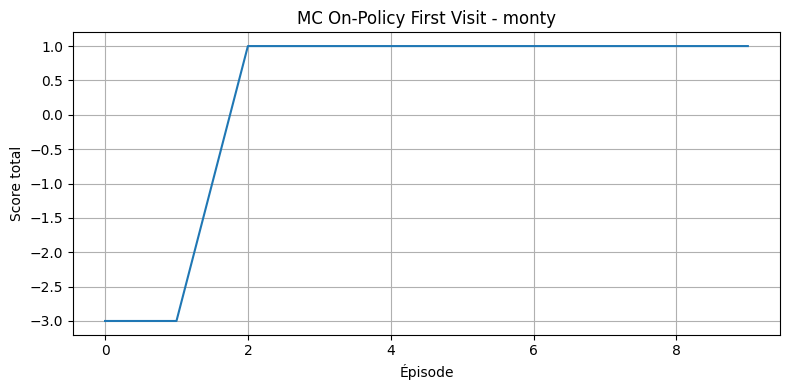

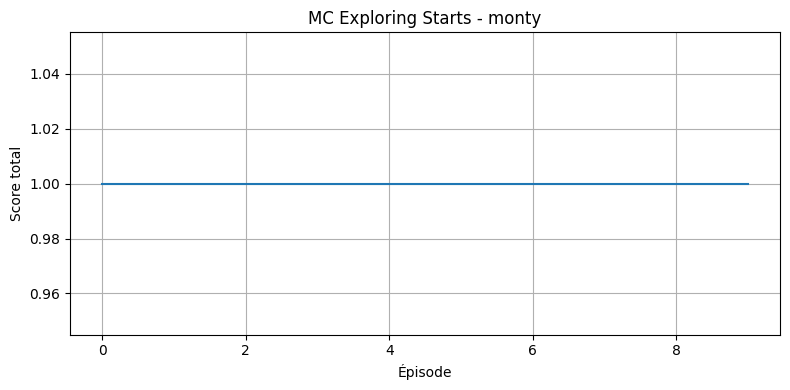

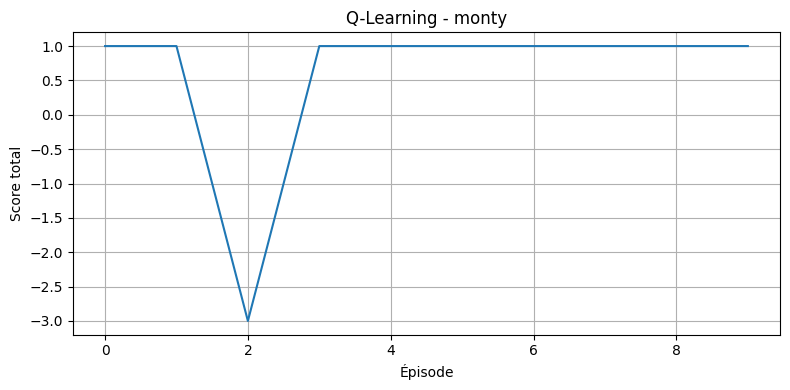

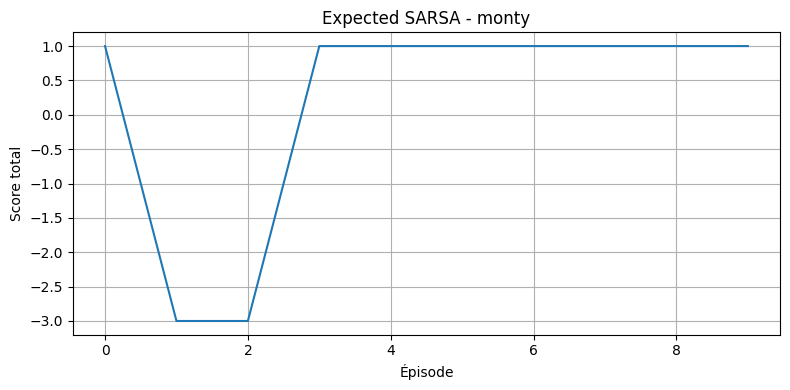

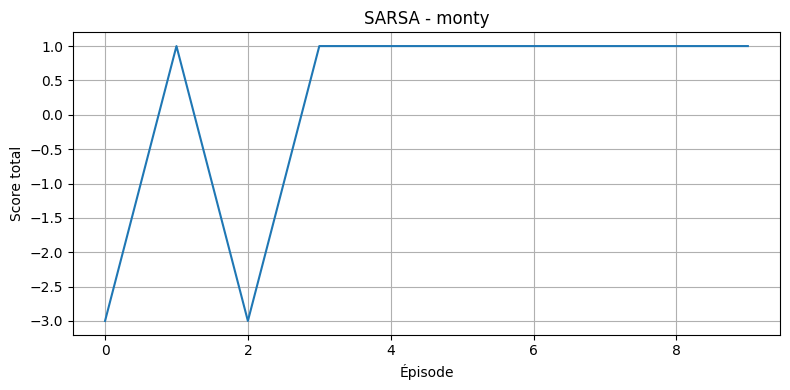

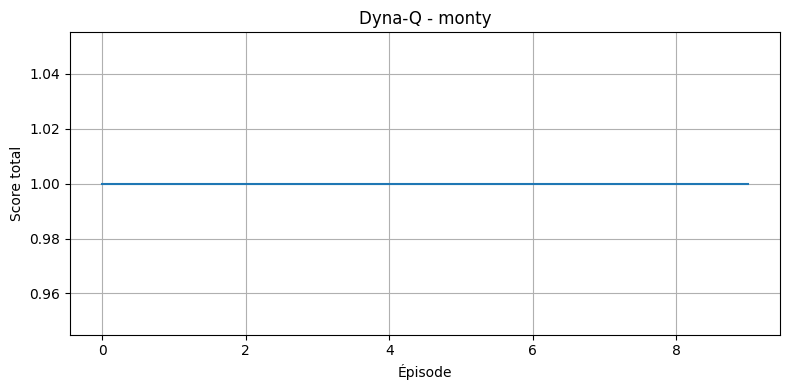

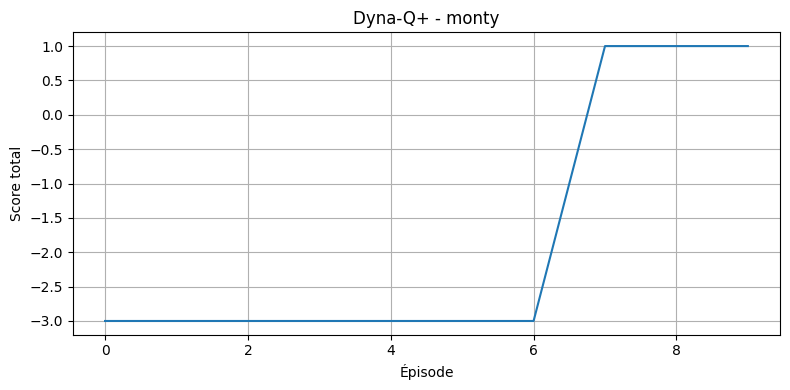

In [9]:
algorithms_data = {
    "Policy Iteration": scores_pi,
    "Value Iteration": scores_vi,
    "MC Off-Policy": scores_mc_off_policy,
    "MC On-Policy": scores_mc_on_policy,
    "MC Exploring Starts": scores_mc_exploring_starts,
    "Q-Learning": scores_q,
    "Expected SARSA": scores_esarsa,
    "SARSA": scores_sarsa,
    "Dyna-Q": scores_dq,
    "Dyna-Q+": scores_dqplus
}

plot_unified(
    algorithms_data, 
    title=f"Comparaison des algorithmes - {env_name}",
    ylabel="Score",
    window=None
)

#### Interpretation 	Monty Hall "Paradox" - Niveau 1 :
 L’environnement Monty Hall niveau 1 étant extrêmement simple et bien connu dans la littérature, il est facilement résolu par les algorithmes de Dynamic Programming, notamment Policy Iteration et Value Iteration. Comme attendu, ces méthodes identifient immédiatement la politique optimale consistant à systématiquement changer de porte lors du second choix, ce qui explique la stabilité et la constance du score observé dès le départ. Les méthodes Monte Carlo (On-Policy, Off-Policy) permettent elles aussi d’atteindre la politique optimale, en exploitant l’échantillonnage des épisodes pour constater l’avantage de changer. Bien que leurs premiers épisodes puissent montrer des fluctuations, la convergence est très rapide. Les algorithmes de Temporal Difference Learning (Q-Learning, Sarsa, Expected Sarsa) convergent également vers la bonne politique. Cependant, ils nécessitent quelques explorations et épisodes pour bien stabiliser l’apprentissage, ce qui se reflète dans leurs premières oscillations avant convergence. Enfin, les méthodes de Planning telles que Dyna-Q ou Dyna-Q+ sont peu adaptées ici, car l’environnement est déjà simple, totalement connu et n’exige aucune construction de modèle pour atteindre la solution optimale. Les performances observées ne montrent d’ailleurs aucun bénéfice particulier lié à ces techniques

### Étude sur l'environnement MontyHallLevel2MDP

In [12]:
env_name = "monty_level2"
env_class = MontyHallLevel2MDP 



# Policy Iteration
policy_pi, V_pi, _ = run_experiment(
    env_class, policy_iteration, "policy_iteration", env_name,
    gamma=0.99, theta=1e-6, max_iterations=1000)
scores_pi = evaluate_policy_score(env_class(), policy_pi, nb_episodes=10)
summary_pi = summarize_policy_scores(scores_pi)
print("Policy Iteration summary:", summary_pi)

# Pour Value Iteration
policy_vi, V_vi, _ = run_experiment(env_class, value_iteration, "value_iteration", env_name,
    gamma=0.99, theta=1e-6, max_iterations=1000)
scores_vi = evaluate_policy_score(env_class(), policy_vi, nb_episodes=10)
summary_vi = summarize_policy_scores(scores_vi)
print("Value Iteration summary:", summary_vi)

# Pour Monte Carlo Off-Policy Control 
policy_mc_exploring_starts, Q_mc_exploring_starts, scores_mc_exploring_starts = run_experiment(
    env_class, mc_exploring_starts, "Monte Carlo Exploring Starts", env_name,
    nb_episodes=10, gamma=0.99
)

# Pour Monte Carlo Off-Policy Control
policy_mc_off_policy, Q_mc_off_policy, scores_mc_off_policy = run_experiment(
    env_class, mc_off_policy_control, "Monte Carlo Off-Policy", env_name,
   nb_episodes=10, gamma=0.99)


# MC On-policy First Visit
policy_mc_on_policy, Q_mc_on_policy, scores_mc_on_policy = run_experiment(
    env_class, mc_on_policy_first_visit, "Monte Carlo On-Policy First Visit", env_name,
    nb_episodes=10, gamma=0.99, epsilon=0.01)

# MC Exploring Starts
policy_mc_exploring_starts, Q_mc_exploring_starts, scores_mc_exploring_starts = run_experiment(
    env_class, mc_exploring_starts, "Monte Carlo Exploring Starts", env_name,
    nb_episodes=10, gamma=0.99)

Policy Iteration:   0%|          | 0/1000 [00:00<?, ?it/s]


Politique et valeurs sauvegardées pour monty_level2 avec policy_iteration


Évaluation de la politique: 100%|██████████| 10/10 [00:00<00:00, 6055.88it/s]


Policy Iteration summary: {'mean': np.float64(0.3), 'std': np.float64(0.45825756949558394), 'min': np.float64(0.0), 'max': np.float64(1.0)}
Politique et valeurs sauvegardées pour monty_level2 avec value_iteration


Évaluation de la politique: 100%|██████████| 10/10 [00:00<00:00, 5389.06it/s]


Value Iteration summary: {'mean': np.float64(0.2), 'std': np.float64(0.4000000000000001), 'min': np.float64(0.0), 'max': np.float64(1.0)}


MC Exploring Starts: 100%|██████████| 10/10 [00:00<00:00, 2275.80it/s]


#### Comparaison graphique des performances

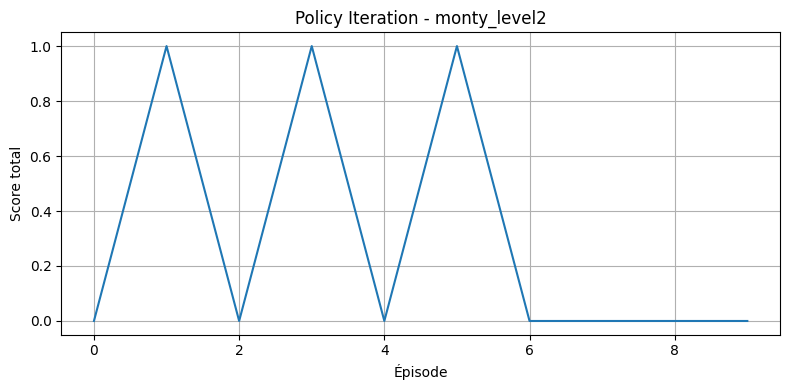

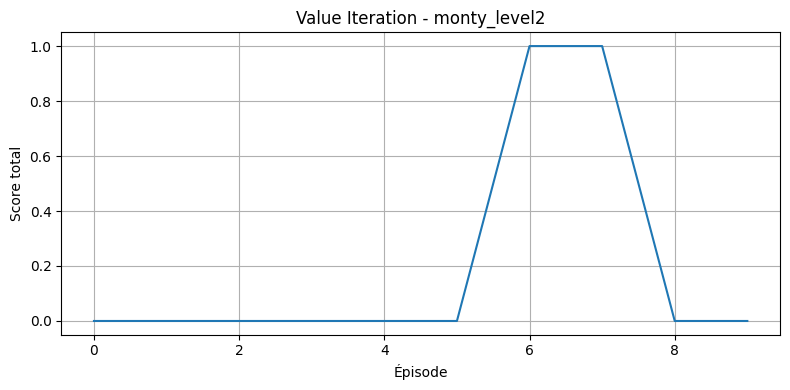

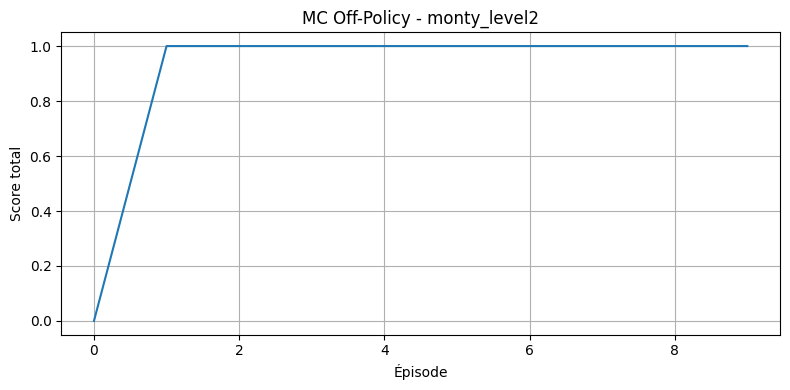

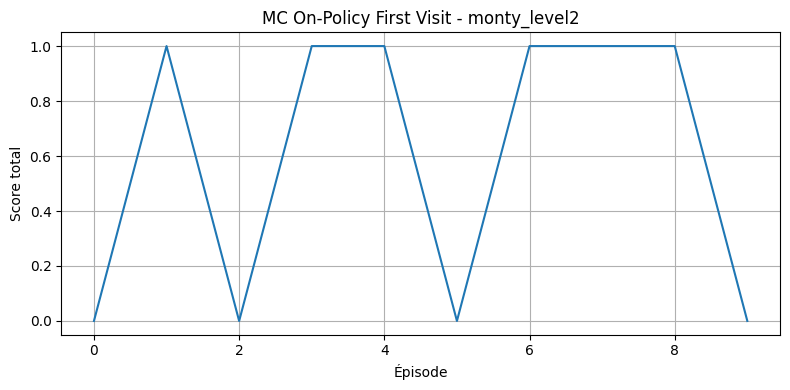

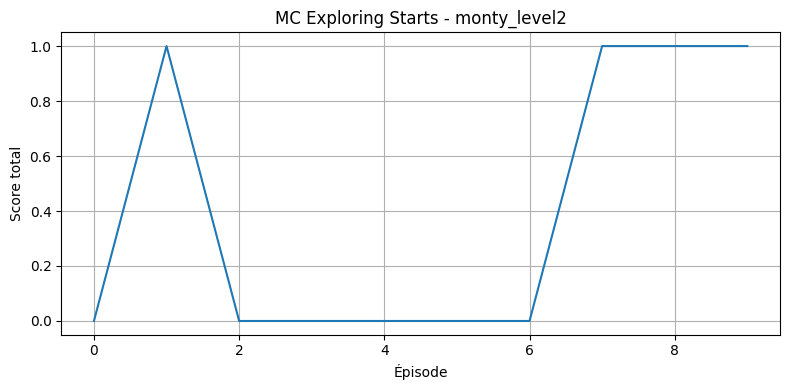

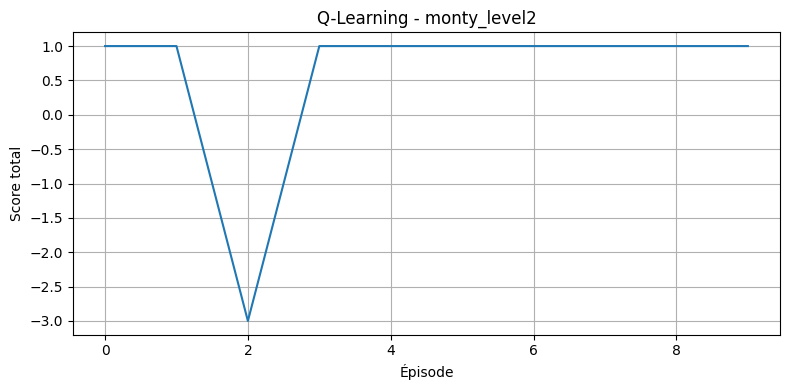

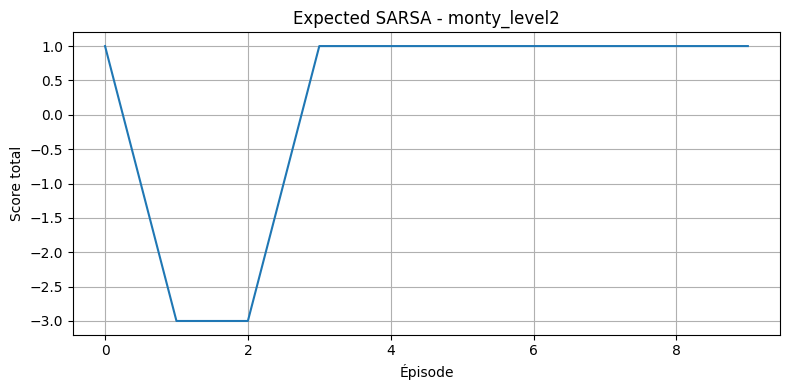

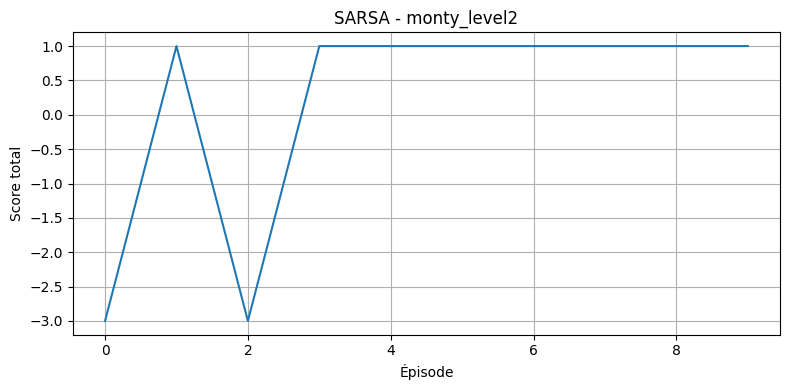

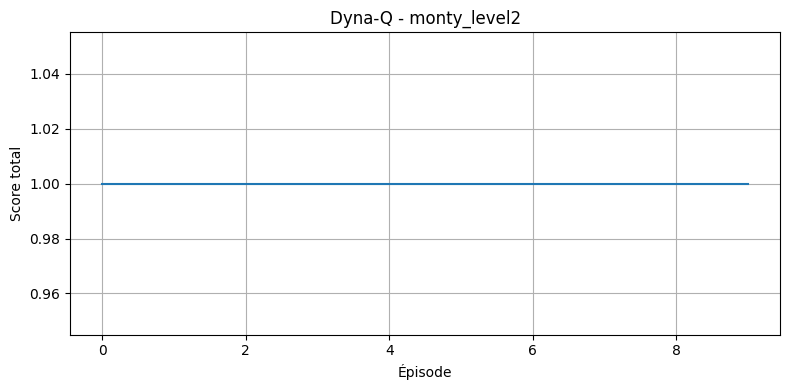

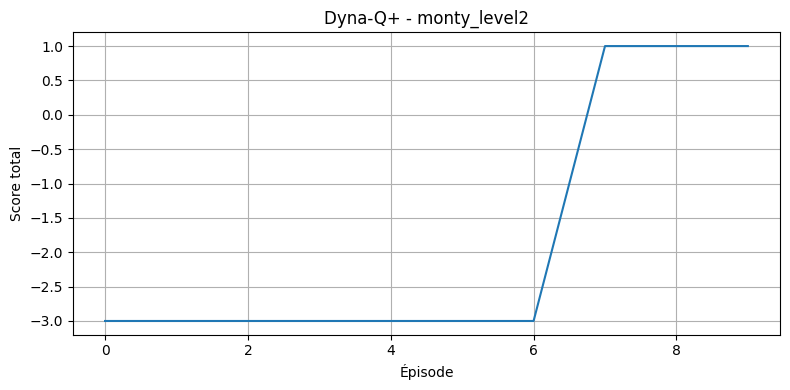

In [ ]:
algorithms_data = {
    "Policy Iteration": scores_pi,
    "Value Iteration": scores_vi,
    "MC Off-Policy": scores_mc_off_policy,
    "MC On-Policy": scores_mc_on_policy,
    "MC Exploring Starts": scores_mc_exploring_starts,
    "Q-Learning": scores_q,
    "Expected SARSA": scores_esarsa,
    "SARSA": scores_sarsa,
    "Dyna-Q": scores_dq,
    "Dyna-Q+": scores_dqplus
}

plot_unified(
    algorithms_data, 
    title=f"Comparaison des algorithmes - {env_name}",
    ylabel="Score",
    window=None
)

#### Interpretation Monty Hall "Paradox" - Niveau 2 :
 Le niveau 2 du problème de Monty Hall est plus complexe que le premier car il introduit un plus grand nombre de portes et nécessite plusieurs étapes d’élimination successives avant la décision finale. Cela rend la politique optimale moins immédiate à identifier. On constate que les algorithmes de Dynamic Programming comme Policy Iteration ou Value Iteration atteignent des résultats corrects mais oscillent davantage en raison de la structure séquentielle et plus profonde de l’environnement. Les méthodes Monte Carlo sont bien adaptées ici : elles permettent d’explorer les différentes séquences d’actions et d’ajuster la politique en fonction de l’expérience, ce qui se traduit par une convergence assez rapide pour Off-Policy et plus oscillante pour On-Policy First Visit. Les algorithmes TD Learning (Q-Learning, Sarsa, Expected Sarsa) finissent par converger après quelques épisodes d’exploration, malgré des débuts parfois erratiques. Cela est dû à la nécessité de comprendre que les choix initiaux influencent les étapes finales. Enfin, les méthodes de planning telles que Dyna-Q ou Dyna-Q+ n’apportent que peu d’avantages dans cet environnement simple mais séquentiel. Elles fonctionnent, mais n’apportent pas d’efficacité particulière par rapport aux autres approches

# Avec l'environment RockPaperScissorsMDP :

In [17]:
env_name = "rps"
env_class = RockPaperScissorsMDP 


# Policy Iteration
policy_pi, V_pi, _ = run_experiment(
    env_class, policy_iteration, "policy_iteration", env_name,
    gamma=0.99, theta=1e-6, max_iterations=1000)
scores_pi = evaluate_policy_score(env_class(), policy_pi, nb_episodes=10)
summary_pi = summarize_policy_scores(scores_pi)
print("Policy Iteration summary:", summary_pi)

# Pour Value Iteration
policy_vi, V_vi, _ = run_experiment(env_class, value_iteration, "value_iteration", env_name,
    gamma=0.99, theta=1e-6, max_iterations=1000)
scores_vi = evaluate_policy_score(env_class(), policy_vi, nb_episodes=10)
summary_vi = summarize_policy_scores(scores_vi)
print("Value Iteration summary:", summary_vi)

# Pour Monte Carlo Off-Policy Control 
policy_mc_exploring_starts, Q_mc_exploring_starts, scores_mc_exploring_starts = run_experiment(
    env_class, mc_exploring_starts, "Monte Carlo Exploring Starts", env_name,
    nb_episodes=10, gamma=0.99
)

# Pour Monte Carlo Off-Policy Control
policy_mc_off_policy, Q_mc_off_policy, scores_mc_off_policy = run_experiment(
    env_class, mc_off_policy_control, "Monte Carlo Off-Policy", env_name,
   nb_episodes=10, gamma=0.99)


# MC On-policy First Visit
policy_mc_on_policy, Q_mc_on_policy, scores_mc_on_policy = run_experiment(
    env_class, mc_on_policy_first_visit, "Monte Carlo On-Policy First Visit", env_name,
    nb_episodes=10, gamma=0.99, epsilon=0.01)

policy_mc_exploring_starts, Q_mc_exploring_starts, scores_mc_exploring_starts = run_experiment(
    env_class, mc_exploring_starts, "Monte Carlo Exploring Starts", env_name,
    nb_episodes=10, gamma=0.99)

Policy Iteration:   0%|          | 0/1000 [00:00<?, ?it/s]


Politique et valeurs sauvegardées pour rps avec policy_iteration


Évaluation de la politique: 100%|██████████| 10/10 [00:00<00:00, 7162.40it/s]


Policy Iteration summary: {'mean': np.float64(-0.1), 'std': np.float64(0.8306623862918076), 'min': np.float64(-1.0), 'max': np.float64(1.0)}
Politique et valeurs sauvegardées pour rps avec value_iteration


Évaluation de la politique: 100%|██████████| 10/10 [00:00<00:00, 16371.21it/s]


Value Iteration summary: {'mean': np.float64(0.1), 'std': np.float64(0.8306623862918076), 'min': np.float64(-1.0), 'max': np.float64(1.0)}


MC Exploring Starts: 100%|██████████| 10/10 [00:00<00:00, 7089.76it/s]


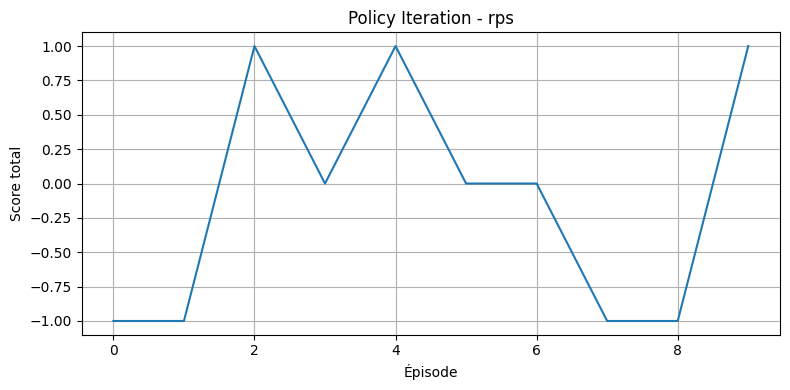

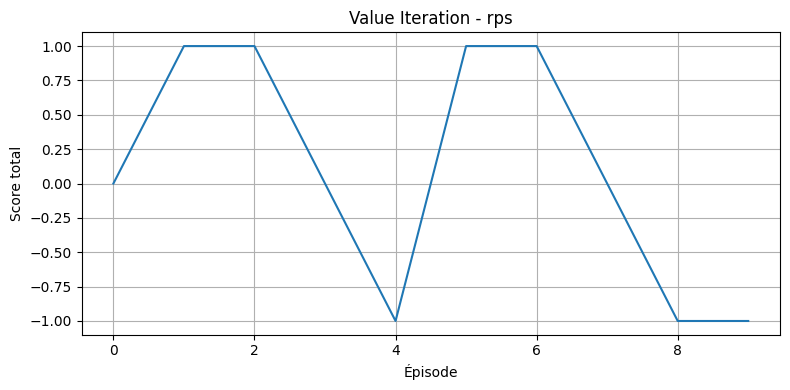

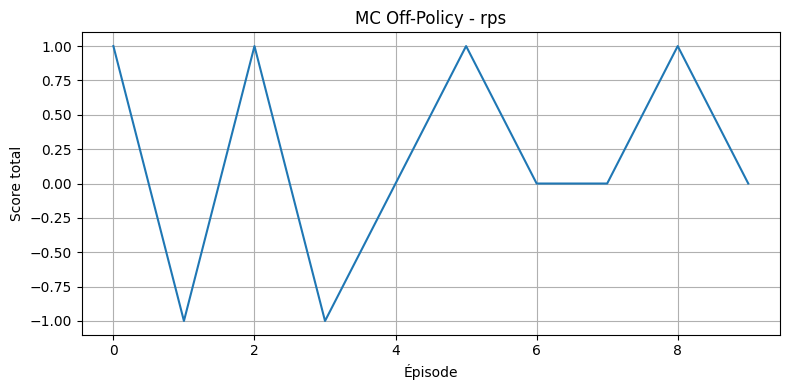

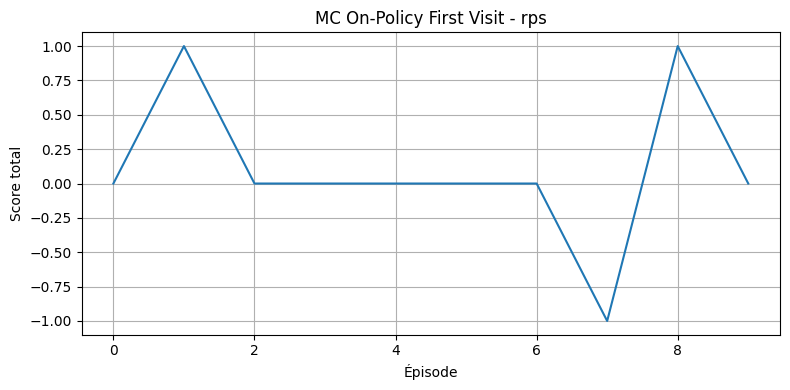

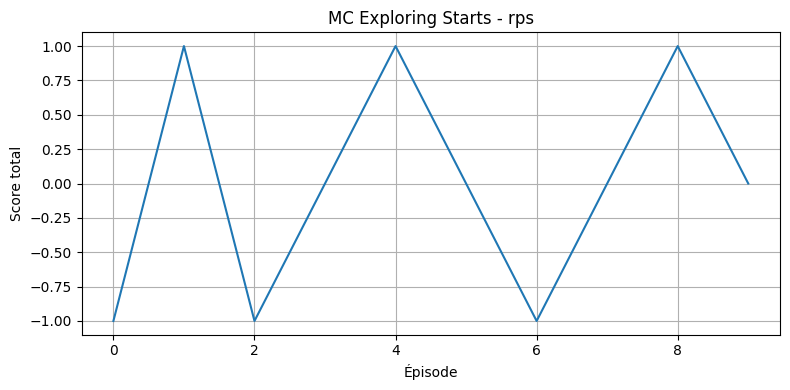

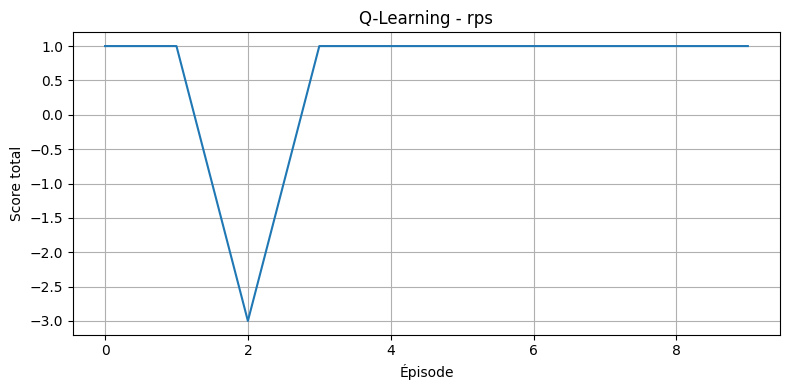

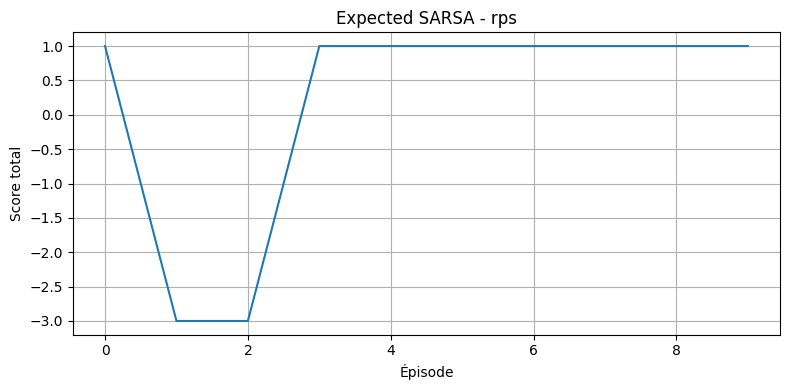

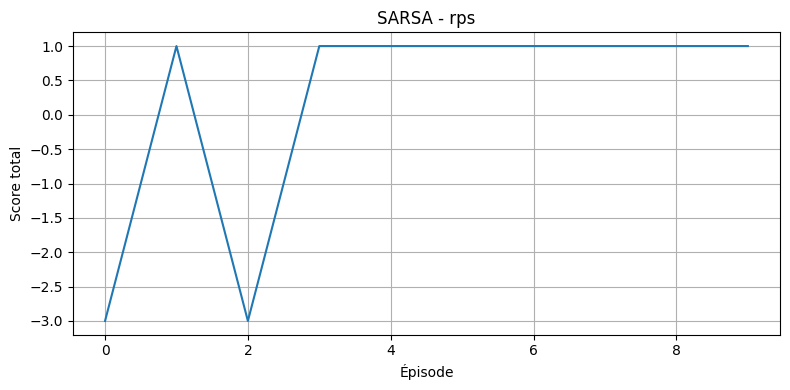

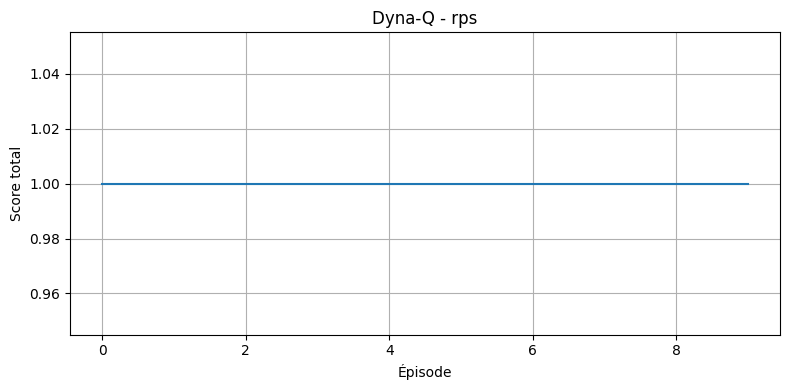

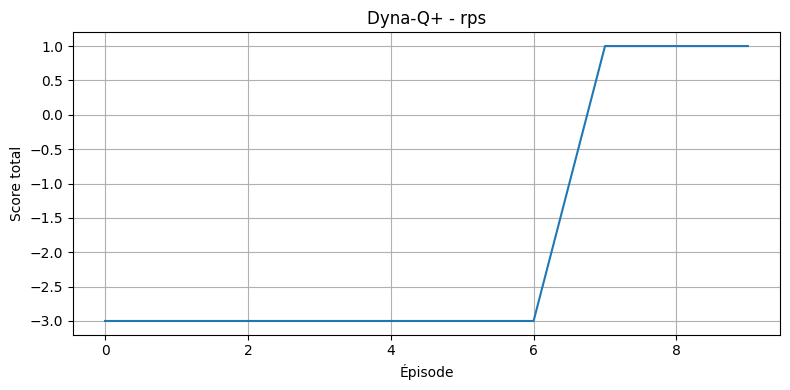

In [18]:

algorithms_data = {
    "Policy Iteration": scores_pi,
    "Value Iteration": scores_vi,
    "MC Off-Policy": scores_mc_off_policy,
    "MC On-Policy": scores_mc_on_policy,
    "MC Exploring Starts": scores_mc_exploring_starts,
    "Q-Learning": scores_q,
    "Expected SARSA": scores_esarsa,
    "SARSA": scores_sarsa,
    "Dyna-Q": scores_dq,
    "Dyna-Q+": scores_dqplus
}

plot_unified(
    algorithms_data, 
    title=f"Comparaison des algorithmes - {env_name}",
    ylabel="Score",
    window=None
)

# avec l'env rps_two_rounds 

In [19]:
env_name = "rps_two_rounds"
env_class = TwoRoundRPS 


# Policy Iteration
policy_pi, V_pi, _ = run_experiment(
    env_class, policy_iteration, "policy_iteration", env_name,
    gamma=0.99, theta=1e-6, max_iterations=1000)
scores_pi = evaluate_policy_score(env_class(), policy_pi, nb_episodes=10)
summary_pi = summarize_policy_scores(scores_pi)
print("Policy Iteration summary:", summary_pi)

# Pour Value Iteration
policy_vi, V_vi, _ = run_experiment(env_class, value_iteration, "value_iteration", env_name,
    gamma=0.99, theta=1e-6, max_iterations=1000)
scores_vi = evaluate_policy_score(env_class(), policy_vi, nb_episodes=10)
summary_vi = summarize_policy_scores(scores_vi)
print("Value Iteration summary:", summary_vi)

# Pour Monte Carlo Off-Policy Control 
policy_mc_exploring_starts, Q_mc_exploring_starts, scores_mc_exploring_starts = run_experiment(
    env_class, mc_exploring_starts, "Monte Carlo Exploring Starts", env_name,
    nb_episodes=10, gamma=0.99
)

# Pour Monte Carlo Off-Policy Control
policy_mc_off_policy, Q_mc_off_policy, scores_mc_off_policy = run_experiment(
    env_class, mc_off_policy_control, "Monte Carlo Off-Policy", env_name,
   nb_episodes=10, gamma=0.99)


# MC On-policy First Visit
policy_mc_on_policy, Q_mc_on_policy, scores_mc_on_policy = run_experiment(
    env_class, mc_on_policy_first_visit, "Monte Carlo On-Policy First Visit", env_name,
    nb_episodes=10, gamma=0.99, epsilon=0.01)

policy_mc_exploring_starts, Q_mc_exploring_starts, scores_mc_exploring_starts = run_experiment(
    env_class, mc_exploring_starts, "Monte Carlo Exploring Starts", env_name,
    nb_episodes=10, gamma=0.99)

Policy Iteration:   0%|          | 2/1000 [00:02<17:54,  1.08s/it]


Politique et valeurs sauvegardées pour rps_two_rounds avec policy_iteration


Évaluation de la politique: 100%|██████████| 10/10 [00:00<00:00, 21399.51it/s]


Policy Iteration summary: {'mean': np.float64(0.6), 'std': np.float64(0.66332495807108), 'min': np.int64(0), 'max': np.int64(2)}
Politique et valeurs sauvegardées pour rps_two_rounds avec value_iteration


Évaluation de la politique: 100%|██████████| 10/10 [00:00<00:00, 42238.71it/s]


Value Iteration summary: {'mean': np.float64(1.1), 'std': np.float64(0.7), 'min': np.int64(0), 'max': np.int64(2)}


MC Exploring Starts: 100%|██████████| 10/10 [00:00<00:00, 3357.32it/s]


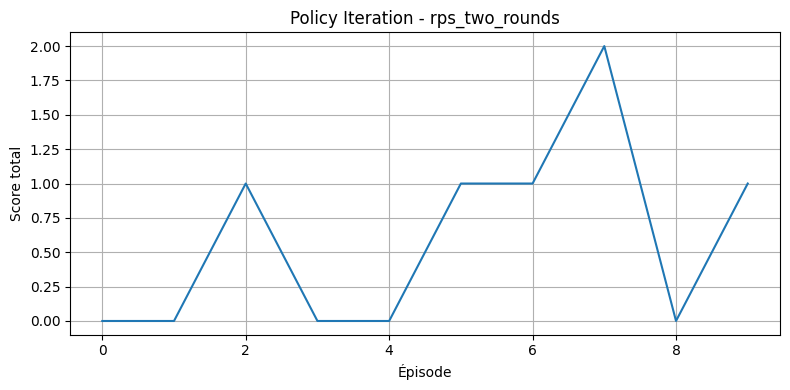

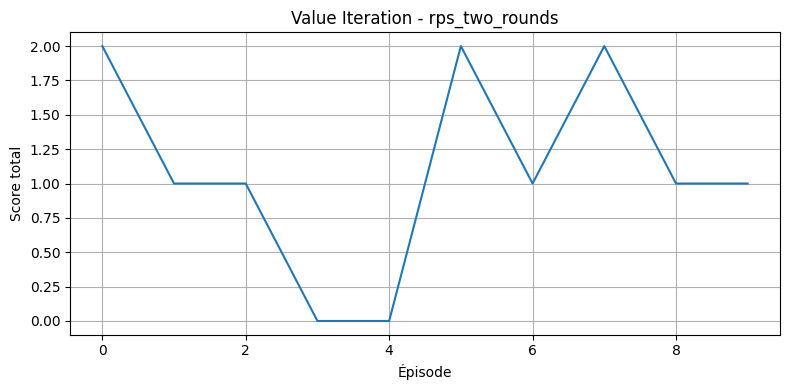

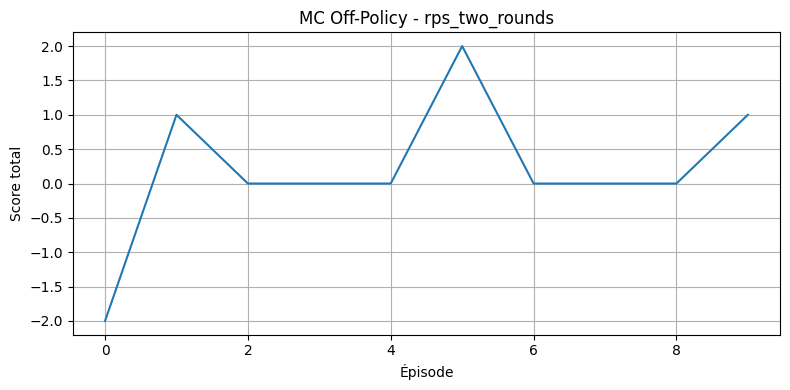

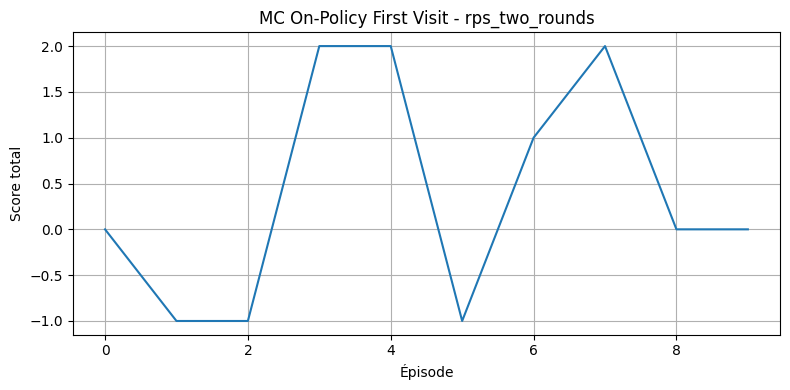

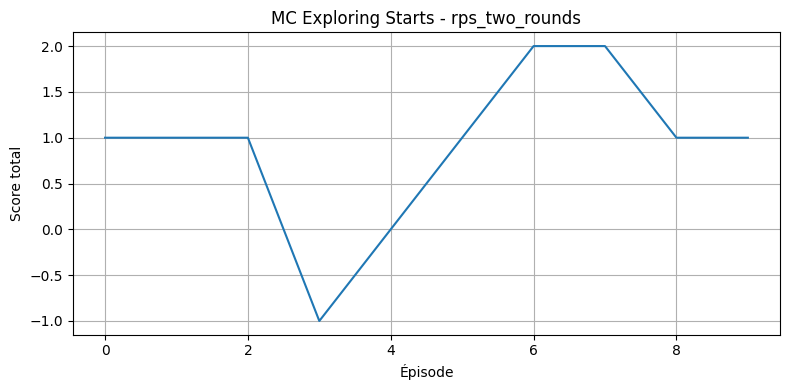

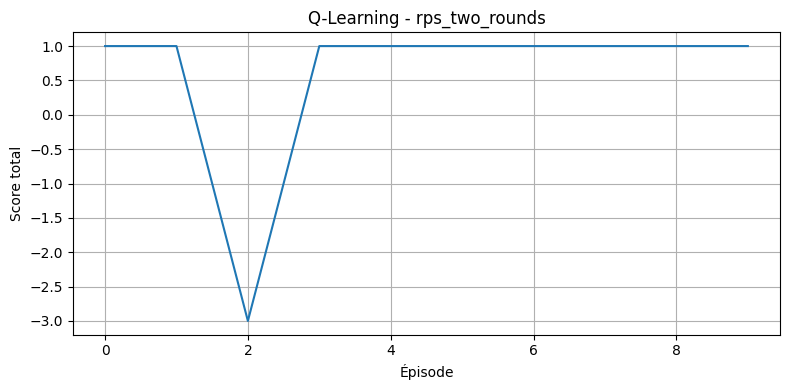

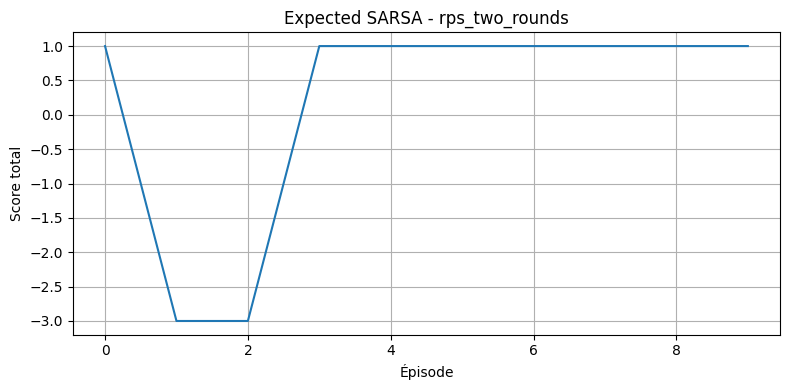

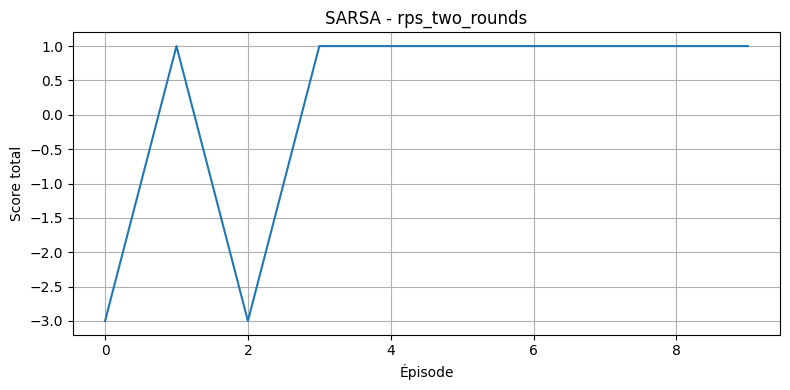

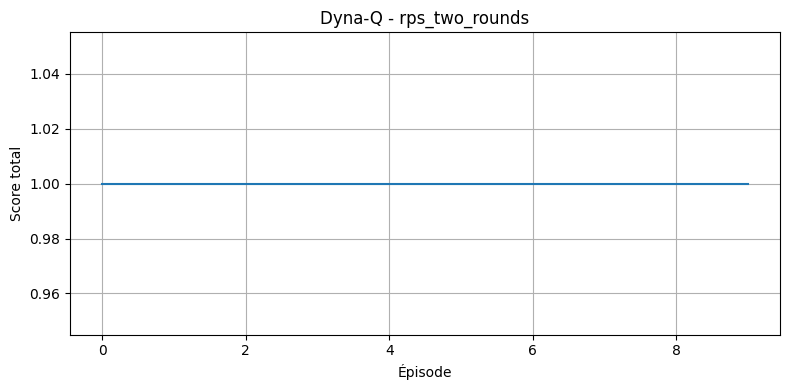

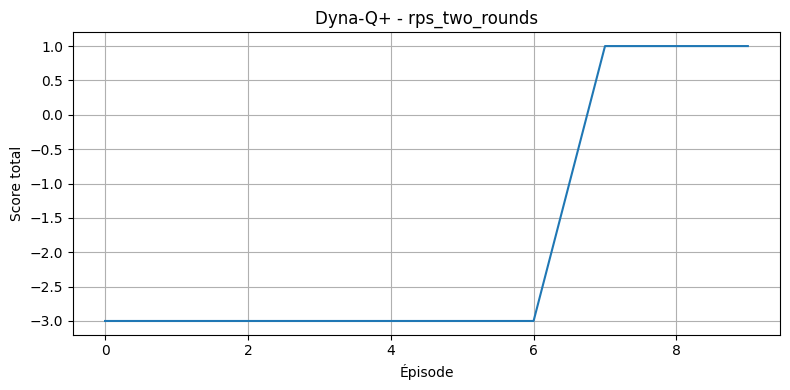

In [20]:

algorithms_data = {
    "Policy Iteration": scores_pi,
    "Value Iteration": scores_vi,
    "MC Off-Policy": scores_mc_off_policy,
    "MC On-Policy": scores_mc_on_policy,
    "MC Exploring Starts": scores_mc_exploring_starts,
    "Q-Learning": scores_q,
    "Expected SARSA": scores_esarsa,
    "SARSA": scores_sarsa,
    "Dyna-Q": scores_dq,
    "Dyna-Q+": scores_dqplus
}

plot_unified(
    algorithms_data, 
    title=f"Comparaison des algorithmes - {env_name}",
    ylabel="Score",
    window=None
)

#### Interpretation :two round rock paper scissors :
 L’environnement Two Round Rock Paper Scissors est très particulier car il repose à la fois sur un comportement aléatoire de l’adversaire lors du premier tour et sur un comportement totalement déterministe au second (copie du choix de l’agent). Cela génère une dynamique où l'agent doit anticiper non seulement le résultat du premier tour, mais surtout exploiter l’information du second pour optimiser son score global. Les méthodes de Dynamic Programming (Policy Iteration, Value Iteration) ne sont pas bien adaptées à cet environnement, car le faible nombre d’états et l’aléatoire du premier tour rendent difficile la modélisation d’une politique fixe réellement optimale. Cela se reflète par des résultats très irréguliers au fil des épisodes. Les méthodes Monte Carlo, qu’elles soient On-Policy ou Off-Policy, parviennent à mieux exploiter la structure du problème grâce à l’échantillonnage des épisodes complets, même si leurs performances restent variables selon les séquences de jeux rencontrées. On observe qu'elles peuvent rapidement atteindre un score élevé, mais oscillent encore entre gains et pertes. Du côté des méthodes TD Learning (Q-Learning, Sarsa, Expected Sarsa), on constate qu’elles finissent par stabiliser des politiques correctes malgré des débuts chaotiques. Elles bénéficient de la simplicité de l’environnement pour converger, mais les fluctuations des résultats montrent que quelques épisodes d’exploration sont nécessaires pour intégrer pleinement la mécanique spécifique de l’adversaire. Enfin, Dyna-Q et Dyna-Q+ n’apportent pas d’amélioration notable sur cet environnement. La taille réduite de l’espace d’états et d’actions, ainsi que l’absence de transitions complexes, limitent fortement l’intérêt d’une modélisation supplémentaire pour planifier